In [ ]:
!pip install dm-sonnet dm-tree
!pip install image-similarity-measures #FSIM
!pip install phasepack
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.4/268.4 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 60.4 MB/s eta 0:00:00
  Created wheel for phasepack: filename=phasepack-1.5-py3-none-any.whl size=26961 sha256=b21305352ac0e2659d943f326fc0a4e8a7f9d039e9a8d79d52b70d67dc6d8a82
  Stored in directory: /root/.cache/pip/wheels/05/37/63/26a896aa2113f7eac15120c277787dcdad4a9b70cace22251f
Successfully built phasepack
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.24.0
    Uninstalling scikit-image-0.24.0:
      Successfully uninstalled scikit-image-0.24.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.15 requires scikit-image>=0.21.0, but you have scikit-image 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import tree

import matplotlib.image as mpimg
import scipy.stats as stats
import matplotlib.pyplot as pl

from sklearn.model_selection import train_test_split

# from image_similarity_measures.quality_metrics import fsim

try:
  import sonnet.v2 as snt
  tf.enable_v2_behavior()
except ImportError:
  import sonnet as snt

print("TensorFlow version {}".format(tf.__version__))
print("Sonnet version {}".format(snt.__version__))

TensorFlow version 2.17.0
Sonnet version 2.0.2


In [ ]:
tf.keras.backend.set_floatx('float32')

# data

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import os
os.chdir("/content/drive/MyDrive/data_exchange/")

Mounted at /content/drive


In [ ]:
dataset = np.float32(np.load('pv4.npy')[::50,])

In [ ]:
dataset.shape

(2000, 64, 64, 1)

In [ ]:
def norm_train(x,min_x,max_x):
  return (x-min_x)/(max_x-min_x)-0.5
  #-0.5 0.5

In [ ]:
# normalize data
dataset =norm_train(dataset,dataset.min(),dataset.max())

# split train/val/test
train_data_dict, test_data_dict = train_test_split(dataset, test_size=0.15)
test_data_dict, valid_data_dict = train_test_split(test_data_dict, test_size=0.05)

In [ ]:
train_data_dict.shape

(1700, 64, 64, 1)

In [ ]:
dataset_bad = np.float32(np.load('pv2.npy')[::50,])

In [ ]:
dataset_bad = norm_train(dataset_bad,dataset_bad.min(),dataset_bad.max())

In [ ]:
nx = dataset.shape[1]

In [ ]:
# dataset_shuffle = dataset.copy()
# np.random.shuffle(dataset_shuffle)

In [ ]:
# train_data_dict = tree.map_structure(lambda x: x[:1000], dataset_shuffle)
# valid_data_dict = tree.map_structure(lambda x: x[1000:1400], dataset_shuffle)
# test_data_dict = tree.map_structure(lambda x: x[1400:], dataset_shuffle)

In [ ]:
def cast_and_normalise_images(data_dict):
  """Convert images to floating point with the range [-0.5, 0.5]"""
  #images = data_dict['image']
  #data_dict['image'] = (tf.cast(images, tf.float32) / 255.0) - 0.5
  return data_dict

#train_data_variance = np.var(train_data_dict['image'] / 255.0)
train_data_variance = np.var(train_data_dict )

print('train data variance: %s' % train_data_variance)

#This does nothing because it was orginally requried to convert images into float32

train data variance: 0.018984467


In [ ]:
import tensorflow as tf

def fsim(
    org_img: tf.Tensor, pred_img: tf.Tensor, T1: float = 0.85, T2: float = 160
) -> tf.Tensor:
    """
    TensorFlow-compatible implementation of the Feature-based similarity index (FSIM).
    FSIM is calculated based on phase congruency (PC) and gradient magnitude (GM).

    Args:
        org_img -- TensorFlow tensor for the original image.
        pred_img -- TensorFlow tensor for the predicted image.
        T1 -- Constant based on the dynamic range of PC values.
        T2 -- Constant based on the dynamic range of GM values.
    """

    def compute_phase_congruency(img):
        # Phase congruency computation - placeholder for actual PC function
        # Replace with a TensorFlow-compatible PC function if available
        return tf.image.sobel_edges(img)  # Example, replace with phase congruency logic

    def compute_gradient_magnitude(img):
        # Compute gradient magnitude using Sobel filter
        sobel = tf.image.sobel_edges(img)
        gm = tf.sqrt(tf.reduce_sum(tf.square(sobel), axis=-1))
        return gm

    def similarity_measure(x, y, T):
        # Similarity measure between tensors x and y
        return (2 * x * y + T) / (tf.square(x) + tf.square(y) + T)

    # Ensure both images have the same shape
    tf.assert_equal(tf.shape(org_img), tf.shape(pred_img), message="FSIM: Image shapes are different")

    if len(org_img.shape) == 2:
        org_img = tf.expand_dims(org_img, axis=-1)
        pred_img = tf.expand_dims(pred_img, axis=-1)

    alpha = beta = 1  # Weighting factors for PC and GM
    fsim_list = []

    for i in range(org_img.shape[-1]):
        pc1 = compute_phase_congruency(org_img[..., i:i+1])
        pc2 = compute_phase_congruency(pred_img[..., i:i+1])

        pc1_sum = tf.reduce_sum(pc1, axis=-1)
        pc2_sum = tf.reduce_sum(pc2, axis=-1)

        gm1 = compute_gradient_magnitude(org_img[..., i:i+1])
        gm2 = compute_gradient_magnitude(pred_img[..., i:i+1])

        # Calculate similarity measures
        S_pc = similarity_measure(pc1_sum, pc2_sum, T1)
        S_g = similarity_measure(gm1, gm2, T2)
        S_l = (S_pc ** alpha) * (S_g ** beta)

        # FSIM computation
        numerator = tf.reduce_sum(S_l * tf.maximum(pc1_sum, pc2_sum))
        denominator = tf.reduce_sum(tf.maximum(pc1_sum, pc2_sum))
        fsim_list.append(numerator / denominator)

    return tf.reduce_mean(fsim_list)


# network

Build the Model

In [ ]:
class ResidualStack(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(ResidualStack, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._layers = []
    for i in range(num_residual_layers):
      conv3 = snt.Conv2D(
          output_channels=num_residual_hiddens,
          kernel_shape=(3, 3),
          stride=(1, 1),
          name="res3x3_%d" % i)
      conv1 = snt.Conv2D(
          output_channels=num_hiddens,
          kernel_shape=(1, 1),
          stride=(1, 1),
          name="res1x1_%d" % i)
      self._layers.append((conv3, conv1))

  def __call__(self, inputs):
    h = inputs
    for conv3, conv1 in self._layers:
      conv3_out = conv3(tf.nn.relu(h))
      conv1_out = conv1(tf.nn.relu(conv3_out))
      h += conv1_out
    return tf.nn.relu(h)  # Resnet V1 style


class Encoder(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(Encoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._enc_1 = snt.Conv2D(
        output_channels=self._num_hiddens // 2,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_1")
    self._enc_2 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_2")
    self._enc_3 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="enc_3")
    self._residual_stack = ResidualStack(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)

  def __call__(self, x):
    h = tf.nn.relu(self._enc_1(x))
    h = tf.nn.relu(self._enc_2(h))
    h = tf.nn.relu(self._enc_3(h))
    return self._residual_stack(h)


class Decoder(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(Decoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._dec_1 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="dec_1")
    self._residual_stack = ResidualStack(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)
    self._dec_2 = snt.Conv2DTranspose(
        output_channels=self._num_hiddens // 2,
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_2")
    self._dec_3 = snt.Conv2DTranspose(
        output_channels=3,
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_3")

  def __call__(self, x):
    h = self._dec_1(x)
    h = self._residual_stack(h)
    h = tf.nn.relu(self._dec_2(h))
    x_recon = self._dec_3(h)
    return x_recon


class VQVAEModel(snt.Module):
  def __init__(self, encoder, decoder, vqvae, pre_vq_conv1,
               data_variance, name=None):
    super(VQVAEModel, self).__init__(name=name)
    self._encoder = encoder
    self._decoder = decoder
    self._vqvae = vqvae
    self._pre_vq_conv1 = pre_vq_conv1
    self._data_variance = data_variance

  def __call__(self, inputs, is_training):
    z = self._pre_vq_conv1(self._encoder(inputs))
    vq_output = self._vqvae(z, is_training=is_training)
    x_recon = self._decoder(vq_output['quantize'])
    recon_error = 1 - fsim(inputs, x_recon[:,:,:,0:1])
    # recon_error = tf.reduce_mean((x_recon - inputs) ** 2) / self._data_variance #replace with FSIM?
    loss = recon_error + vq_output['loss']
    return {
        'z': z,
        'x_recon': x_recon,
        'loss': loss,
        'recon_error': recon_error,
        'vq_output': vq_output,
    }

Set parameters

In [ ]:
# Set hyper-parameters.
batch_size = nx
image_size = nx

# 100k steps should take < 30 minutes on a modern (>= 2017) GPU.
# 10k steps gives reasonable accuracy with VQVAE on Cifar10.
num_training_updates = 10000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
# These hyper-parameters define the size of the model (number of parameters and layers).
# The hyper-parameters in the paper were (For ImageNet):
# batch_size = 128
# image_size = 128
# num_hiddens = 128
# num_residual_hiddens = 32
# num_residual_layers = 2

# This value is not that important, usually 64 works.
# This will not change the capacity in the information-bottleneck.
embedding_dim = 64

# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 512

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = True

# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4


# # Data Loading.
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_data_dict)
    .map(cast_and_normalise_images)
    .shuffle(10000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size, drop_remainder=True)
    .prefetch(-1))

valid_dataset = (
    tf.data.Dataset.from_tensor_slices(valid_data_dict)
    .map(cast_and_normalise_images)
    .repeat(1)  # 1 epoch
    .batch(batch_size)
    .prefetch(-1))

# # Build modules.
encoder = Encoder(num_hiddens, num_residual_layers, num_residual_hiddens)
decoder = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens)
pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim,
    kernel_shape=(1, 1),
    stride=(1, 1),
    name="to_vq")

if vq_use_ema:
  vq_vae = snt.nets.VectorQuantizerEMA(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost,
      decay=decay)
else:
  vq_vae = snt.nets.VectorQuantizer(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost)

model = VQVAEModel(encoder, decoder, vq_vae, pre_vq_conv1,
                   data_variance=train_data_variance)

optimizer = snt.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(data):
  with tf.GradientTape() as tape:
    model_output = model(data, is_training=True)
  trainable_variables = model.trainable_variables
  grads = tape.gradient(model_output['loss'], trainable_variables)
  optimizer.apply(grads, trainable_variables)

  return model_output

# def train_step(data):
#   with tf.GradientTape() as tape:
#       model_output = model(data, is_training=True)
#       # Ensure the loss is reduced to a scalar if it's not already
#       loss = tf.reduce_mean(model_output['loss'])

#   trainable_variables = model.trainable_variables
#   grads = tape.gradient(loss, trainable_variables)
#   optimizer.apply_gradients(zip(grads, trainable_variables))

#   return model_output



# def train_step(data):
#   with tf.GradientTape() as tape:
#     model_output = model(data, is_training=True)
#     # Convert tensors to NumPy arrays before calculating FSIM
#     model_output['recon_error'] = tf.numpy_function(
#         fsim,
#         [data, model_output['x_recon'][:,:,:,0:1]],
#         tf.float64
#     )
#   trainable_variables = model.trainable_variables
#   grads = tape.gradient(model_output['loss'], trainable_variables)
#   optimizer.apply(grads, trainable_variables)

#   return model_output

# def train_step(data):
#   with tf.GradientTape() as tape:
#     model_output = model(data, is_training=True)
#     # Convert tensors to NumPy arrays before calculating FSIM
#     # and then convert the result back to a TensorFlow tensor
#     model_output['recon_error'] = tf.cast(tf.numpy_function(
#         fsim,
#         [data.numpy(), model_output['x_recon'][:,:,:,0:1].numpy()], # Convert to NumPy arrays
#         tf.float64
#     ), tf.float32)  # Convert back to TensorFlow tensor with correct dtype
#   trainable_variables = model.trainable_variables
#   grads = tape.gradient(model_output['loss'], trainable_variables)
#   optimizer.apply(grads, trainable_variables)

#   return model_output

# def train_step(data):
#   with tf.GradientTape() as tape:
#     model_output = model(data, is_training=True)
#   # Calculate FSIM outside the GradientTape context using NumPy arrays
#   recon_error = tf.cast(fsim(data.numpy(), model_output['x_recon'][:,:,:,0:1].numpy()), tf.float32)
#   # Assign the calculated recon_error to model_output
#   model_output['recon_error'] = recon_error
#   # Recalculate loss with updated recon_error
#   loss = model_output['recon_error'] + model_output['vq_output']['loss']
#   model_output['loss'] = loss #update model_output['loss'] so that gradient can be calculated against this loss

#   trainable_variables = model.trainable_variables
#   grads = tape.gradient(model_output['loss'], trainable_variables)
#   optimizer.apply(grads, trainable_variables)

#   return model_output

train_losses = []
train_recon_errors = []
train_perplexities = []
train_vqvae_loss = []

for step_index, data in enumerate(train_dataset):

  train_results = train_step(data)
  train_losses.append(train_results['loss'])
  train_recon_errors.append(train_results['recon_error'])
  train_perplexities.append(train_results['vq_output']['perplexity'])
  train_vqvae_loss.append(train_results['vq_output']['loss'])

  if (step_index + 1) % 100 == 0:
    print('%d train loss: %f ' % (step_index + 1,
                                   np.mean(train_losses[-100:])) +
          ('recon_error: %.3f ' % np.mean(train_recon_errors[-100:])) +
          ('perplexity: %.3f ' % np.mean(train_perplexities[-100:])) +
          ('vqvae loss: %.3f' % np.mean(train_vqvae_loss[-100:])))
  if step_index == num_training_updates:
    break

100 train loss: 0.243443 recon_error: 0.217 perplexity: 13.229 vqvae loss: 0.027
200 train loss: 0.114419 recon_error: 0.057 perplexity: 19.914 vqvae loss: 0.057
300 train loss: 0.055993 recon_error: -0.006 perplexity: 29.151 vqvae loss: 0.062
400 train loss: -0.013916 recon_error: -0.073 perplexity: 35.561 vqvae loss: 0.059
500 train loss: 0.116454 recon_error: -0.344 perplexity: 16.900 vqvae loss: 0.460
600 train loss: 0.370359 recon_error: -0.124 perplexity: 19.926 vqvae loss: 0.494
700 train loss: 0.215385 recon_error: -0.300 perplexity: 17.341 vqvae loss: 0.515
800 train loss: -0.032738 recon_error: -1.558 perplexity: 22.570 vqvae loss: 1.525
900 train loss: -0.245862 recon_error: -0.971 perplexity: 29.520 vqvae loss: 0.725
1000 train loss: 0.984465 recon_error: 0.147 perplexity: 18.315 vqvae loss: 0.837
1100 train loss: 0.624386 recon_error: 0.553 perplexity: 9.625 vqvae loss: 0.071
1200 train loss: 0.237885 recon_error: 0.192 perplexity: 10.603 vqvae loss: 0.046
1300 train loss:

In [ ]:
# @tf.function(input_signature=[tf.TensorSpec([None, nx,nx,1])])
# def inference(x):
#   return model(x, is_training = False)

# to_save = snt.Module()
# to_save.inference = inference
# # to_save.train_losses = train_losses
# to_save.all_variables = list(model.variables)
# tf.saved_model.save(to_save, "example_saved_model")

# #successful! see data_exchange folder

In [ ]:
# nx = 64;

# loaded = tf.saved_model.load("example_saved_model")

# # Use the inference method. Note this doesn't run the Python code from `to_save`
# # but instead uses the TensorFlow Graph that is part of the saved model.
# loaded.inference(tf.ones([1, nx,nx,1]))

# # The all_variables property can be used to retrieve the restored variables.
# assert len(loaded.all_variables) > 0

In [ ]:
# loaded(tf.ones([1, nx,nx,1]))

In [ ]:
# test = loaded.inference(tf.ones([1, nx,nx,1]))
# test['x_recon']
# test['z']

In [ ]:
# dataset_noise=valid_data_dict+np.float32(np.random.uniform(-0.05,0.05,valid_data_dict.shape))

# out = model(dataset_noise, is_training = False)

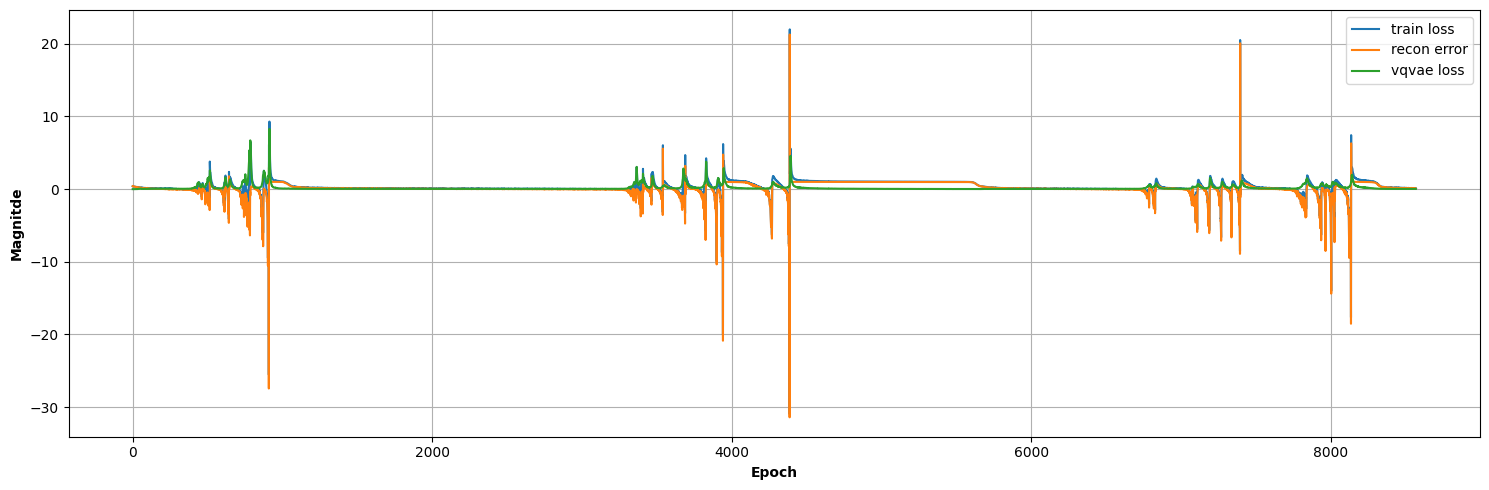

In [ ]:
plt.figure(figsize = (15,5))

plt.plot(train_losses, label = 'train loss')
plt.plot(train_recon_errors, label = 'recon error')
plt.plot(train_vqvae_loss, label = 'vqvae loss')

plt.grid()
plt.legend()
plt.xlabel('Epoch', fontweight = 'bold')
plt.ylabel('Magnitde', fontweight = 'bold')

plt.tight_layout()

plt.savefig('losses')

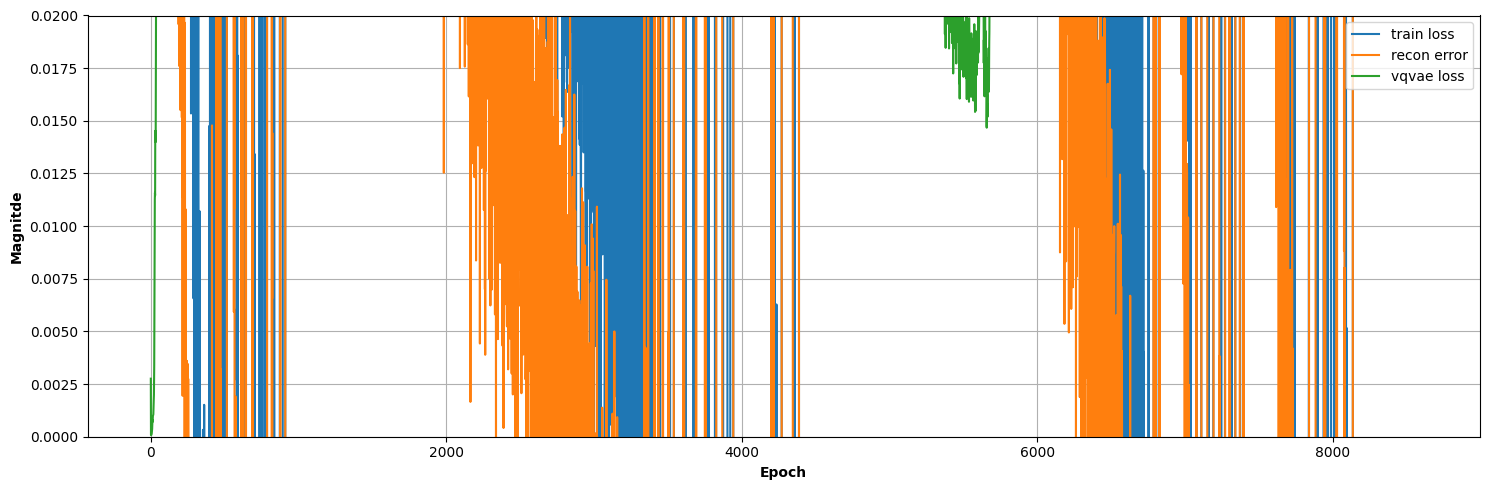

In [ ]:
plt.figure(figsize = (15,5))

plt.plot(train_losses, label = 'train loss')
plt.plot(train_recon_errors, label = 'recon error')
plt.plot(train_vqvae_loss, label = 'vqvae loss')

plt.grid()
plt.legend()
plt.xlabel('Epoch', fontweight = 'bold')
plt.ylabel('Magnitde', fontweight = 'bold')
plt.ylim([0, 0.02])

plt.tight_layout()

plt.savefig('losses_zoom')

# Evaluate/ rmse

In [ ]:
def rmse(a,b):
  return np.sqrt(np.mean((a-b)**2))

In [ ]:
dataset_noise=valid_data_dict+np.float32(np.random.uniform(-0.05,0.05,valid_data_dict.shape))

out = model(dataset_noise, is_training = False)
rec_u = out['x_recon'].numpy()
print(rmse(rec_u, valid_data_dict))

NameError: name 'valid_data_dict' is not defined

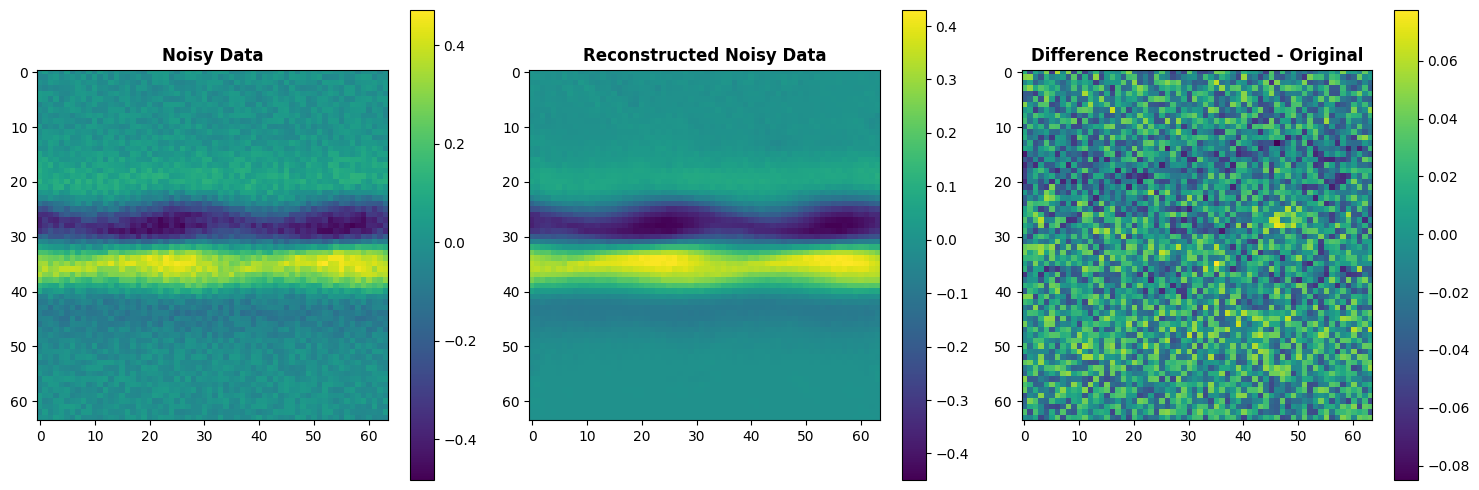

In [ ]:
m = 1

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.imshow(dataset_noise[m,:,:,0])
plt.title('Noisy Data', fontweight = 'bold')
plt.colorbar()

plt.subplot(132)
plt.imshow(rec_u[m,:,:,0])
plt.title('Reconstructed Noisy Data', fontweight = 'bold')
plt.colorbar()

plt.subplot(133)

plt.imshow(rec_u[m,:,:,0]-dataset_noise[m,:,:,0]) #, cmap = 'seismic'
plt.title('Difference Reconstructed - Original', fontweight = 'bold')
plt.colorbar()

plt.tight_layout()

plt.savefig('noise_recon')

In [ ]:
data_good_1 = dataset[100,:,:,0]
data_good_2 = dataset[1300,:,:,0]
data_good_3 = dataset[-100,:,:,0]

In [ ]:
out = model(dataset, is_training = False)
rec_good= out['x_recon'].numpy()

In [ ]:
rec_good_1 = rec_good[100,:,:,0]
rec_good_2 = rec_good[1300,:,:,0]
rec_good_3 = rec_good[-100,:,:,0]

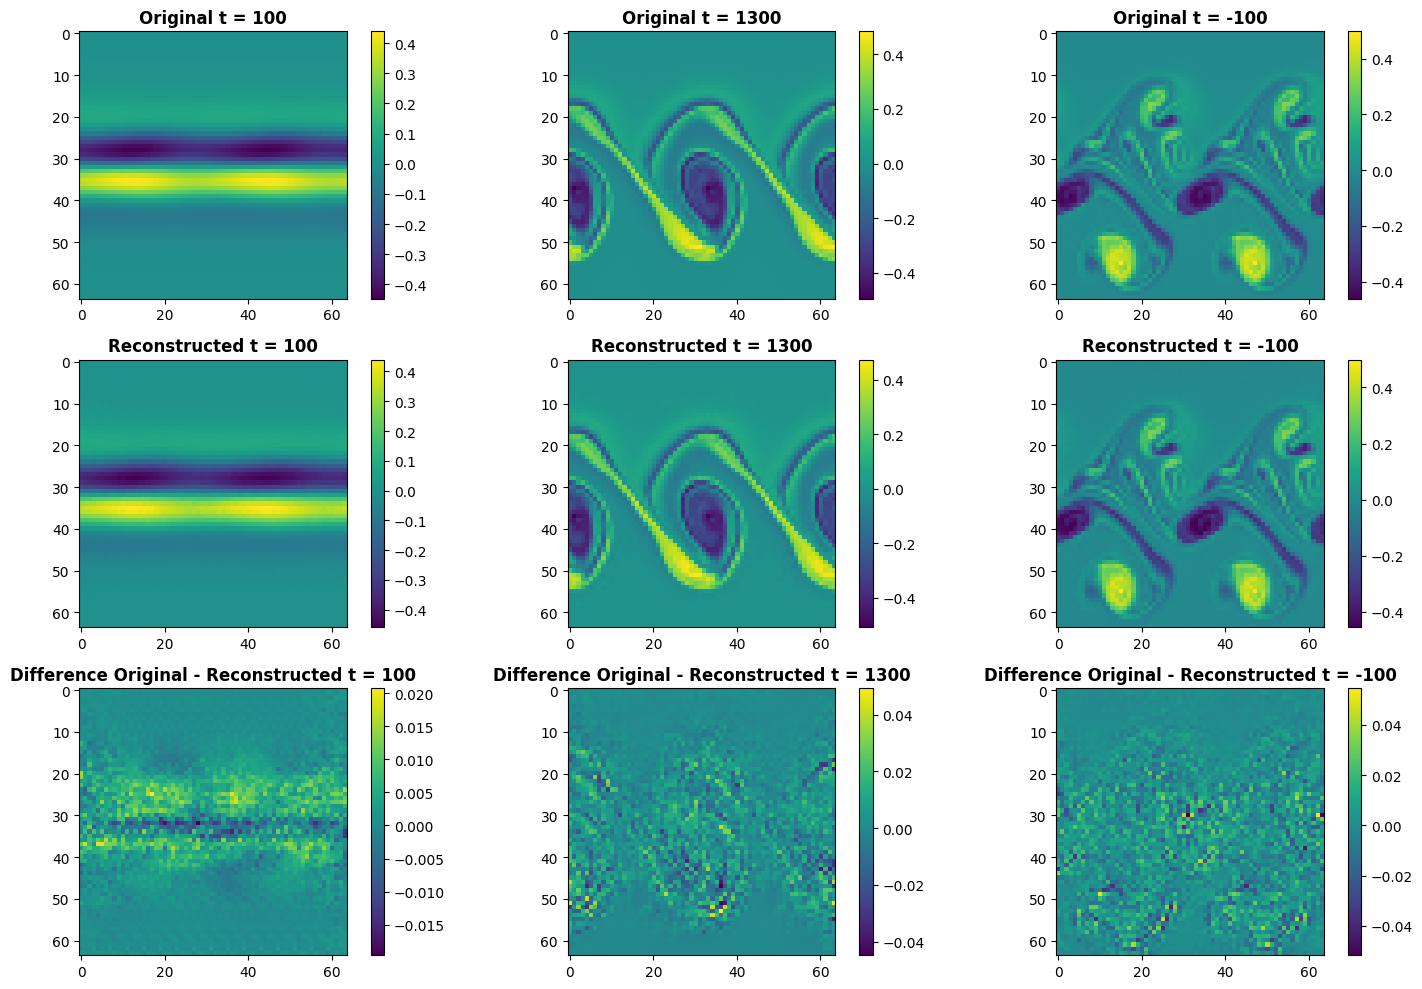

In [ ]:
plt.figure(figsize = (15,10))

plt.subplot(331)
plt.imshow(data_good_1)
plt.colorbar()
plt.title('Original t = 100', fontweight = 'bold')

plt.subplot(332)
plt.imshow(data_good_2)
plt.colorbar()
plt.title('Original t = 1300', fontweight = 'bold')

plt.subplot(333)
plt.imshow(data_good_3)
plt.colorbar()
plt.title('Original t = -100', fontweight = 'bold')

plt.subplot(334)
plt.imshow(rec_good_1)
plt.colorbar()
plt.title('Reconstructed t = 100', fontweight = 'bold')

plt.subplot(335)
plt.imshow(rec_good_2)
plt.colorbar()
plt.title('Reconstructed t = 1300', fontweight = 'bold')

plt.subplot(336)
plt.imshow(rec_good_3)
plt.colorbar()
plt.title('Reconstructed t = -100', fontweight = 'bold')

plt.subplot(337)
plt.imshow(data_good_1 - rec_good_1)
plt.colorbar()
plt.title('Difference Original - Reconstructed t = 100', fontweight = 'bold')

plt.subplot(338)
plt.imshow(data_good_2 - rec_good_2)
plt.colorbar()
plt.title('Difference Original - Reconstructed t = 1300', fontweight = 'bold')

plt.subplot(339)
plt.imshow(data_good_3 - rec_good_3)
plt.colorbar()
plt.title('Difference Original - Reconstructed t = -100', fontweight = 'bold')

plt.tight_layout()

plt.savefig('data_good')

In [ ]:
data_bad_1 = dataset_bad[100,:,:,0]
data_bad_2 = dataset_bad[1300,:,:,0]
data_bad_3 = dataset_bad[-100,:,:,0]

In [ ]:
out = model(dataset_bad, is_training = False)
rec_bad = out['x_recon'].numpy()

In [ ]:
rec_bad_1 = rec_bad[100,:,:,0]
rec_bad_2 = rec_bad[1300,:,:,0]
rec_bad_3 = rec_bad[-100,:,:,0]

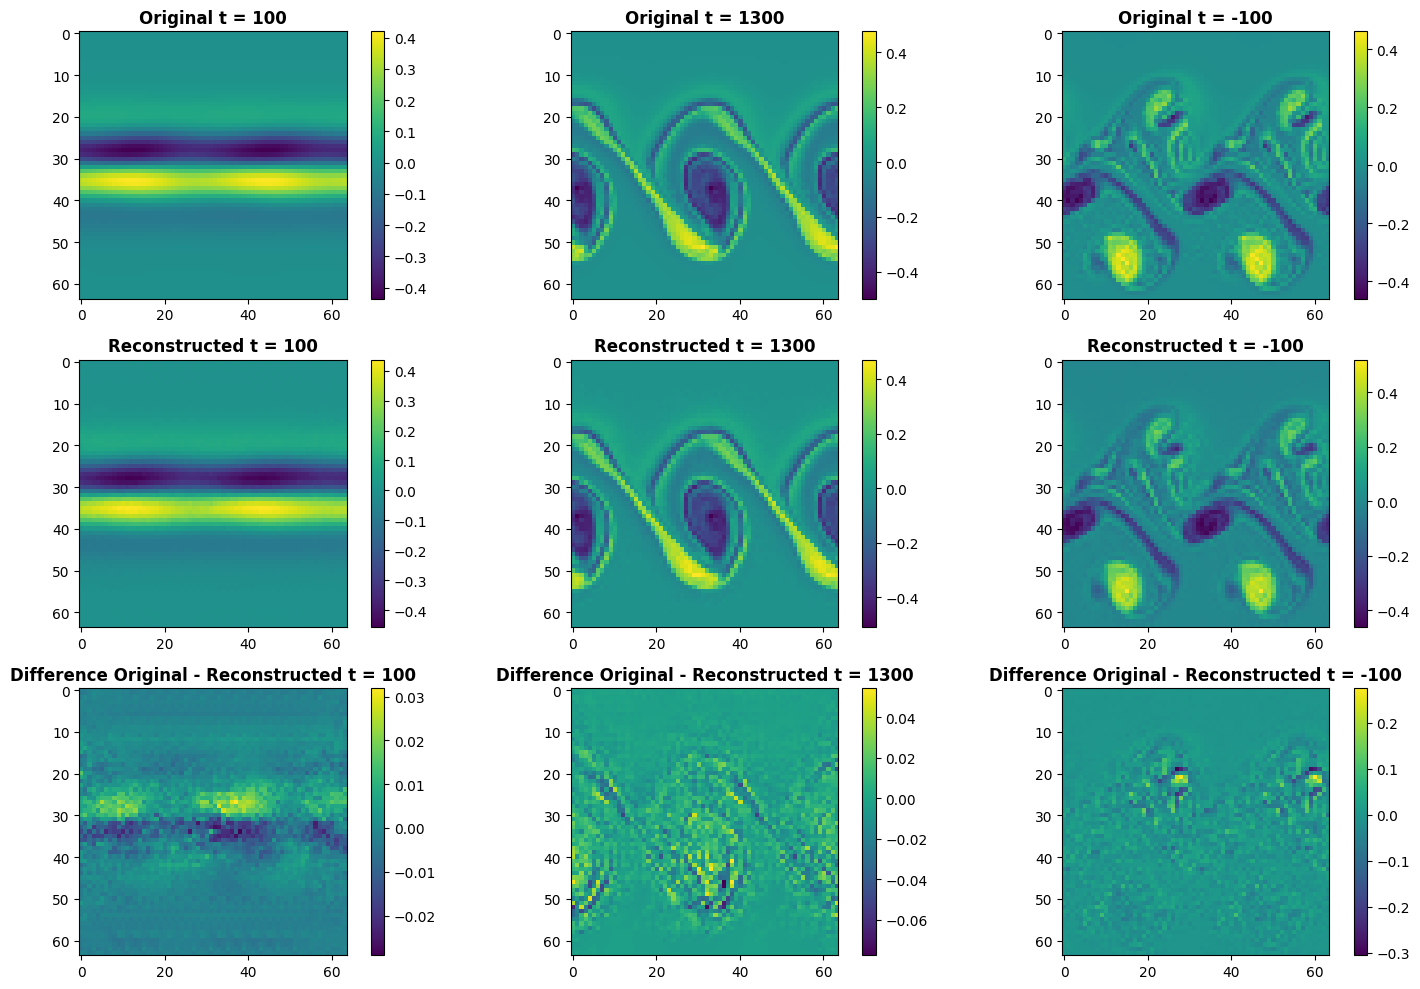

In [ ]:
plt.figure(figsize = (15,10))

plt.subplot(331)
plt.imshow(data_bad_1)
plt.colorbar()
plt.title('Original t = 100', fontweight = 'bold')

plt.subplot(332)
plt.imshow(data_bad_2)
plt.colorbar()
plt.title('Original t = 1300', fontweight = 'bold')

plt.subplot(333)
plt.imshow(data_bad_3)
plt.colorbar()
plt.title('Original t = -100', fontweight = 'bold')

plt.subplot(334)
plt.imshow(rec_bad_1)
plt.colorbar()
plt.title('Reconstructed t = 100', fontweight = 'bold')

plt.subplot(335)
plt.imshow(rec_bad_2)
plt.colorbar()
plt.title('Reconstructed t = 1300', fontweight = 'bold')

plt.subplot(336)
plt.imshow(rec_bad_3)
plt.colorbar()
plt.title('Reconstructed t = -100', fontweight = 'bold')

plt.subplot(337)
plt.imshow(data_bad_1 - rec_bad_1)
plt.colorbar()
plt.title('Difference Original - Reconstructed t = 100', fontweight = 'bold')

plt.subplot(338)
plt.imshow(data_bad_2 - rec_bad_2)
plt.colorbar()
plt.title('Difference Original - Reconstructed t = 1300', fontweight = 'bold')

plt.subplot(339)
plt.imshow(data_bad_3 - rec_bad_3)
plt.colorbar()
plt.title('Difference Original - Reconstructed t = -100', fontweight = 'bold')

plt.tight_layout()

plt.savefig('data_bad')

In [ ]:
n = dataset.shape[0]

err_good = np.zeros(n)
err_bad = np.zeros(n)

for i in range(n):

  out = model(dataset[i,None,], is_training = False)
  rec = out['x_recon'].numpy()

  err_good[i] = rmse(rec, dataset[i,None,])

  out = model(dataset_bad[i,None,], is_training = False)
  rec = out['x_recon'].numpy()

  err_bad[i] = rmse(rec, dataset_bad[i, None,])

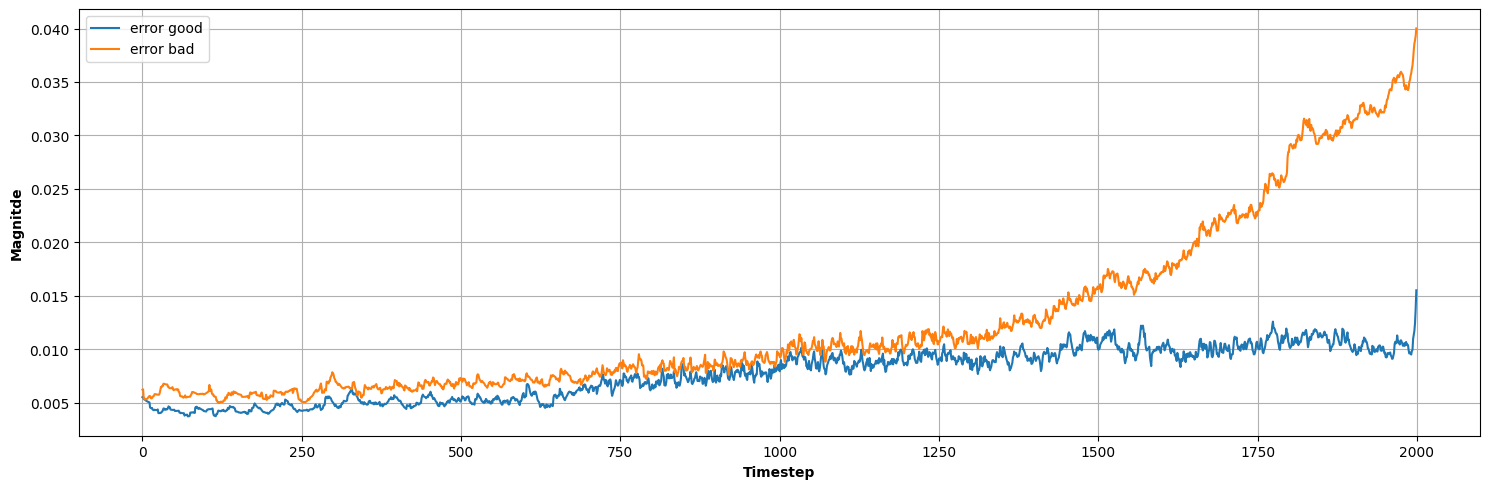

In [ ]:
plt.figure(figsize = (15,5))

plt.plot(err_good, label = 'error good')
plt.plot(err_bad, label = 'error bad')

plt.grid()
plt.legend()
plt.xlabel('Timestep', fontweight = 'bold')
plt.ylabel('Magnitde', fontweight = 'bold')

plt.tight_layout()

plt.savefig('rmse')

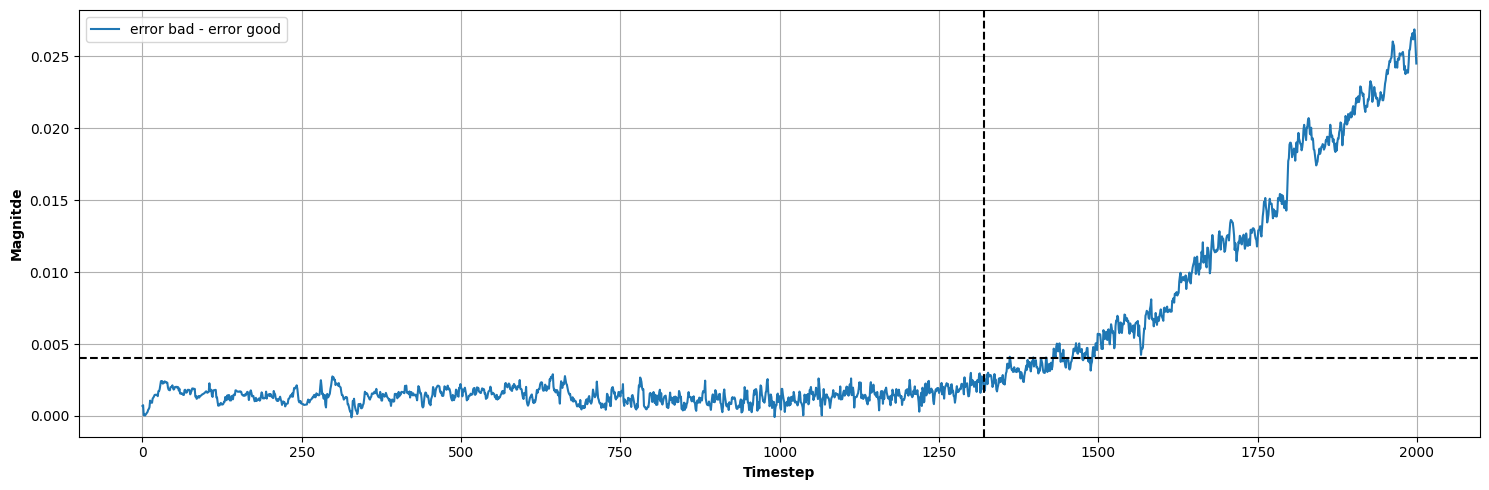

In [ ]:
plt.figure(figsize = (15,5))

plt.plot(err_bad-err_good, label = 'error bad - error good')
plt.axhline(0.004, color = 'black', linestyle = '--')
plt.axvline(1320, color = 'black', linestyle = '--')

plt.grid()
plt.legend()
plt.xlabel('Timestep', fontweight = 'bold')
plt.ylabel('Magnitde', fontweight = 'bold')

plt.tight_layout()

plt.savefig('rmse difference')

In [ ]:
# out = model(valid_data_dict , is_training = False)
# rec_u = out['x_recon'].numpy()
# print(rmse(rec_u, valid_data_dict))

# rec_test_data = cvae.predict(x_test)
# print(rmse(rec_test_data,y_test))

In [ ]:
image_1 = dataset_bad[100]
image_2 = dataset_bad[1300]
image_3 = dataset_bad[-100]

In [ ]:
npix = image_1.shape[0]

fourier_image = np.fft.fftn(image_1)
fourier_amplitudes = np.abs(fourier_image)**2

kfreq = np.fft.fftfreq(npix) * npix
kfreq2D = np.meshgrid(kfreq, kfreq)
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()

kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins_1, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins_1 *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

In [ ]:
npix = image_2.shape[0]

fourier_image = np.fft.fftn(image_2)
fourier_amplitudes = np.abs(fourier_image)**2

kfreq = np.fft.fftfreq(npix) * npix
kfreq2D = np.meshgrid(kfreq, kfreq)
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()

kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins_2, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins_2 *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

In [ ]:
npix = image_3.shape[0]

fourier_image = np.fft.fftn(image_3)
fourier_amplitudes = np.abs(fourier_image)**2

kfreq = np.fft.fftfreq(npix) * npix
kfreq2D = np.meshgrid(kfreq, kfreq)
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()

kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins_3, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins_3 *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

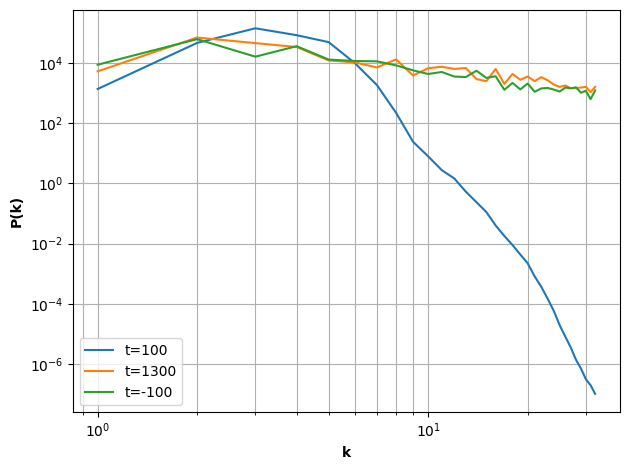

In [ ]:
pl.figure()

pl.loglog(kvals, Abins_1, label = 't=100')
pl.loglog(kvals, Abins_2, label = 't=1300')
pl.loglog(kvals, Abins_3, label = 't=-100')

pl.grid(True, which = 'both')
pl.legend()
pl.xlabel("k", fontweight = 'bold')
pl.ylabel("P(k)", fontweight = 'bold')

pl.tight_layout()

pl.savefig('spectrum')